# **Introduction**

### **Invasive Ductal Carcinoma**
Breast cancer is the most frequent form of cancer affecting women [[source]](https://www.nccs.com.sg/patient-care/cancer-types/cancer-statistics).

Of all subtypes, Invasive Ductal Carcinoma (IDC) is the most common form of breast cancer, representing 80 percent of all breast cancer diagnoses [[source]](https://www.hopkinsmedicine.org/breast_center/breast_cancers_other_conditions/invasive_ductal_carcinoma.html).  IDC grows in the milk duct and invades the fibrous or fatty tissue of the breast outside of the duct. [[source]](https://www.hopkinsmedicine.org/breast_center/breast_cancers_other_conditions/invasive_ductal_carcinoma.html) 

###**Breast Cancer Histopathology**

One way to identify IDC is through a biopsy where a tissue is extracted from the patient and then studied under a microscope by pathologists.  Pathologists then examine the spread of IDC and assign an aggressiveness grade to the sample (grade of cancer). (i.e. the more aggressive the spread of cancer, the higher a grade/stage is given) [[source]](https://www.nhs.uk/common-health-questions/operations-tests-and-procedures/what-do-cancer-stages-and-grades-mean/) 

In short, the delineation of IDC from whole mount slides is important in estimating the tumor aggressiveness (grade of cancer) and predicting patient outcome. [[source]](https://ieeexplore.ieee.org/document/9057822)

 
The analysis of breast cancer biopsys is highly time-consuming and at times, inaccurate. Pathologists have to go through swathes of benign regions in tissue samples to identify areas with IDC and the extent of its spread. 
In addition, the variability of appearance in hematoxylin and eosin (H&E) stained areas presents one of the major barriers to accurate image analysis. Due these factor, detecting and categorizing these deviations can be difficult even for experienced pathologists [[source]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7465368/). 

As such, a machine learning approach will increase efficiency and accuracy, allowing the pathologist to carry out a more detailed appraisal on biopsy scans. 

# **Problem Statement**
A research firm would like to use deep learning to diagnose the presence of IDC in breast histopathological images.  This is a image binary classification problem and the objective is to able to accurately classify image patches into 2 groups: presence of IDC or no IDC.  In particular, we are interested in obtaining a reasonably high balanced accuracy score and recall score.  Elaboration on the chosen metrics will be explained later. 

#**Download Dataset and Libraries**

### **Download Kaggle API and Data**

The dataset was obtained from this [link](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) on kaggle.  

The dataset consist of extractions from Whole Slide Images. Each Whole Slide Image is split into non-overlapping coloured image patches that are 50 by 50 pixels.  Irrelevant patches (mostly fatty tissue or slide background) were discarded. Regions containing IDC were manually annotated by an experienced pathologist. 

In [ ]:
# install kaggle
! pip install kaggle

In [ ]:
# Create directory
! mkdir ~/.kaggle

In [ ]:
# Move kaggle api to directory
! cp kaggle.json ~/.kaggle/

In [ ]:
# Provide permission to file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset from kaggle link
! kaggle datasets download paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [01:27<00:00, 73.1MB/s]
100% 3.10G/3.10G [01:27<00:00, 38.0MB/s]


In [ ]:
# Unzip zipped file
!unzip "breast-histopathology-images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re


%matplotlib inline

from glob import glob
from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    plot_roc_curve,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score
)
import tensorflow as tf
import keras,os
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


import cv2
from google.colab.patches import cv2_imshow
from matplotlib.image import imread


import warnings
warnings.filterwarnings('ignore')

# Preprocessing Data (Part 1)

Next, data will be preprocessed, returning all file paths that match a specific pattern.



In [ ]:
# Return all file paths in the main folder. 
image_patch_all = glob('../content/*', recursive=True)

There are a total of 283 folders - 279 patients in the main file (4 folders are our own folders).



In [ ]:
len(image_patch_all)

283

There are a total of 279 folders in the sub file - images of 279 patients can be found in the sub file.   

In [ ]:
#Return all file paths in the sub folder. 
image_patch = glob('../content/IDC_regular_ps50_idx5/*', recursive=True)

In [ ]:
len(image_patch)

279

Next, I'll create a table with 3 columns: patient_id, pathway and class (whether IDC-positive or normal). 



In [ ]:
# Return file paths that end with .png
all_img_patches_path = glob('../content/IDC_regular_ps50_idx5/*/*/*')

In [ ]:
# Return all patient ids in subfile 
patient_id = []
for i in all_img_patches_path:
  id = i.split('/')[3].split('/')[-1]
  patient_id.append(id)

In [ ]:
# Return all class in subfile
class_presence = []
for i in all_img_patches_path:
  id = i.split('/')[4].split('/')[-1]
  class_presence.append(id)

In [ ]:
# Create dataframe with patient_id, class and path
data_imgs = pd.DataFrame({'patient_id': patient_id, 
                          'path': all_img_patches_path, 
                          'class': class_presence})

In [ ]:
# Convert datatype from object to integer
data_imgs["class"] = data_imgs["class"].astype(int)

In [ ]:
# Observe datatypes of dataframe
data_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   class       277524 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.4+ MB


In [ ]:
# Create additional class0 and class 1 columns 
data_imgs["class_1"] = data_imgs["class"].apply(lambda x: 1 if x == 1 else 0)
data_imgs["class_0"] = data_imgs["class"].apply(lambda x: 1 if x == 0 else 0)

In [ ]:
# Drop columns
class_patients = data_imgs.drop(columns=["path","class"])

Next, we group the dataset by patient ID and find out more about it.   
As can be seen below, all patients tested positive for breast cancer (min = 10 scans).  Each patient had a mix of image patches that are IDC-positive and normal. Typically, a patient will have around an average of 282 IDC-positive scans and 712 normal scans. 

In [ ]:
class_patients_grp = class_patients.groupby("patient_id").sum()
class_patients_grp.describe()

,class_1,class_0
count,279.000000,279.000000
mean,282.387097,712.322581
std,259.236512,476.404878
min,10.000000,14.000000
25%,104.500000,347.500000
50%,198.000000,623.000000
75%,369.500000,998.500000
max,1347.000000,2231.000000


#### **Histogram for distribution of IDC-positive and normal patches per patient** 

Next, we plot a histogram to observe the distribution of IDC-positive and normal patches per person. Both histograms observed a right skewness.  Clearly, there were more normal patches than positive patches. 

In [ ]:
hist_patient = class_patients.groupby("patient_id").sum()

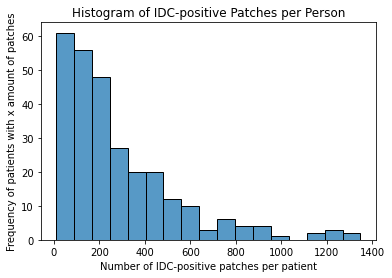

In [ ]:
sns.histplot(data=hist_patient,x=hist_patient["class_1"])
plt.xlabel("Number of IDC-positive patches per patient")
plt.ylabel("Frequency of patients with x amount of patches")
plt.title("Histogram of IDC-positive Patches per Person");

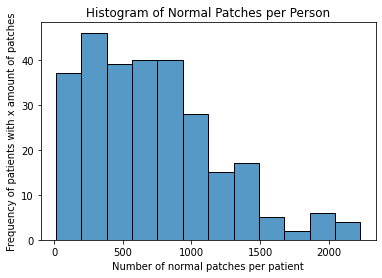

In [ ]:
sns.histplot(data=hist_patient,x=hist_patient["class_0"])
plt.xlabel("Number of normal patches per patient")
plt.ylabel("Frequency of patients with x amount of patches")
plt.title("Histogram of Normal Patches per Person");

### Classify Images

Return all file paths that match a .png and classify filenames that end with class0 into class0 (no IDC) and the rest in class1 (presence of IDC - a common breast cancer subtype)

In [ ]:
# Two arrays holding images by class type

class0 = [] # 0 = no IDC
class1 = [] # 1 = IDC-present, cancer

for file in all_img_patches_path:
    if file.endswith("class0.png"):
         class0.append(file)
    else:
        class1.append(file)

### **Class Imbalance**

Next we observe the imbalance in class and correct imbalance accordingly. 




In [ ]:
# number of normal and IDC scans
print(f'number of normal scans: {len(class0)}')
print(f'number of scans with IDC: {len(class1)}')

number of normal scans: 198738
number of scans with IDC: 78786


In [ ]:
# create dataframe for normal and IDC scans
scan_freq = pd.DataFrame((["IDC (cancer)",len(class1)],
                          ["No IDC",len(class0)]),
                         columns = ["Presence of IDC", "Number of Image Patches"])

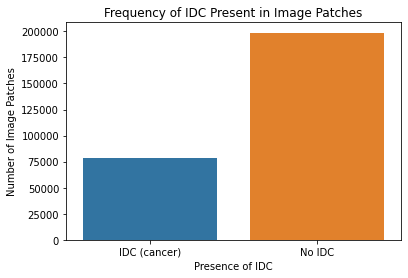

In [ ]:
# Plot barplot
sns.barplot(data=scan_freq, x = "Presence of IDC", y = "Number of Image Patches")
plt.title("Frequency of IDC Present in Image Patches");

As can be seen above, the number of scans with IDC (n=78786) is 39.6% that of the number of scans with no IDC (n=198,738), suggesting that there may be a slight class imbalance.

In the train/test dataset, we will correct for this by randomly sampling equal number patches from both classes for our dataset prior to modelling.  

Given the class imbalance, downsampling was chosen.
While it would be preferred to oversample with augmentation, the dataset was large, with over 270,000 + image patches. It would be computationally more intensive to oversample with augmentation.   

In [ ]:
# Randomly sample equal number of patches from both classes
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)

# EDA

Next, we create a function to plot biopsy images. Biopsy images were randomly selected and viewed. 
Normal images appear to have a lighter stain than IDC-positive images. 

To the untrained eye, it is challenging to differentiate the IDC-positive and normal images.  In general, IDC presence is usually marked by cellular





In [ ]:
# Create function to plot biopsy scans
def showbiopsyimgs(sampled_class):
  random_eda_class = random.sample(sampled_class,25)
  n=1
  plt.figure(figsize=(8, 8))
  for img_path in random_eda_class:
    path_class = plt.imread(img_path)
    plt.subplot(5,5,n)
    plt.imshow(path_class)
    n+=1

25 biopsy images that had no IDC (normal) were randomly selected and viewed.


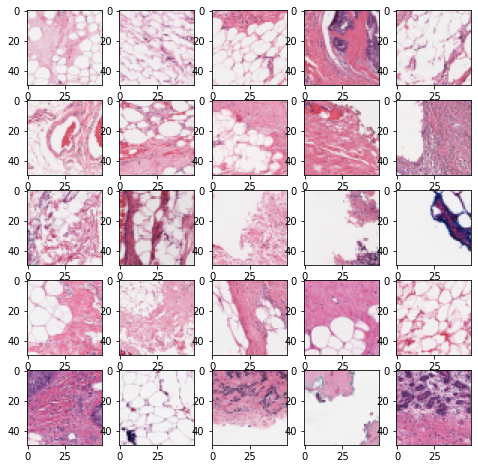

In [ ]:
# Show biopsy images for normal class 
showbiopsyimgs(sampled_class0)

25 biopsy images that had IDC were randomly selected and viewed.

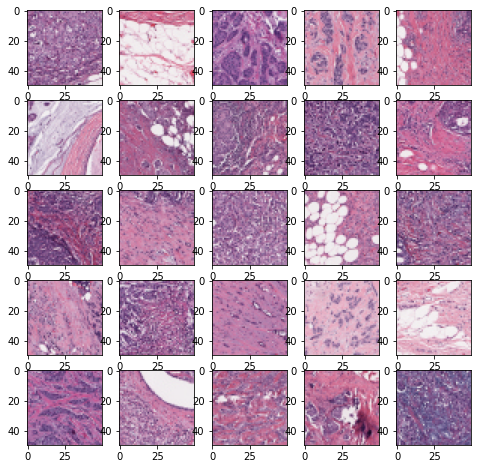

In [ ]:
# Show biopsy images for IDC class 
showbiopsyimgs(sampled_class1)

# Preprocessing data (Part 2)

Next, existing files ending with .png are resized and appended into an image array. Patches that are IDC positive were appended into class1 while patches that were normal were appended into class0.  Array from both classes were concatenanted and shuffled before train-test-split.

In [ ]:
# Create function 
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [ ]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [ ]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [ ]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [ ]:
# shape of X is 50, 50, 3 and will need to be reshaped
X = np.array(X).reshape(-1, 50, 50, 3)

# Train-Test-Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(118179, 50, 50, 3) (39393, 50, 50, 3) (118179, 2) (39393, 2)


# Creating Neural Network Models

### Functions

In [182]:
def plot_grp (history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def summary_table(model):
  summary ={'model': str(model),
            'balanced_accuracy': balanced_accuracy_score(actual_class, preds_class),
      'accuracy': accuracy_score(actual_class, preds_class),
        'specificity': tn / (tn+fp),
        'recall': recall_score(actual_class, preds_class), # (tp / (tp+fn))
        'precision': precision_score(actual_class, preds_class),
        'f1_score': f1_score(actual_class, preds_class)}
        
  summary_df = pd.DataFrame.from_dict(summary, orient = 'index').T
  return summary_df

In [ ]:
def summary_table_1(model):
  summary ={'model': str(model),
            'balanced_accuracy': balanced_accuracy_score(actual_class, preds_class),
        'specificity': tn / (tn+fp),
        'recall': recall_score(actual_class, preds_class)}
  summary_df_v2 = pd.DataFrame.from_dict(summary, orient = 'index').T
  return summary_df_v2

###Baseline Model

A baseline model was created. This is a simple model containing 1 convulational layer, 1 maxpooling layer, 1 dropout layer and 2 connected dense layers. 

In [ ]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(2,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= ['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2166912   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 2,168,738
Trainable params: 2,168,738
Non-trainable params: 0
____________________________________________

In [ ]:
history_bl_v3 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 60,
    verbose = 2,
    steps_per_epoch=200,
    batch_size=512
    )

Epoch 1/60
200/200 - 51s - loss: 14.3350 - accuracy: 0.8325 - val_loss: 0.3716 - val_accuracy: 0.8462
Epoch 2/60
200/200 - 50s - loss: 0.3328 - accuracy: 0.8463 - val_loss: 0.3164 - val_accuracy: 0.8462
Epoch 3/60
200/200 - 51s - loss: 0.3101 - accuracy: 0.8502 - val_loss: 0.3093 - val_accuracy: 0.8679
Epoch 4/60
200/200 - 51s - loss: 0.3077 - accuracy: 0.8663 - val_loss: 0.3075 - val_accuracy: 0.8681
Epoch 5/60
200/200 - 52s - loss: 0.3006 - accuracy: 0.8710 - val_loss: 0.3040 - val_accuracy: 0.8703
Epoch 6/60
200/200 - 52s - loss: 0.2974 - accuracy: 0.8721 - val_loss: 0.3015 - val_accuracy: 0.8701
Epoch 7/60
200/200 - 51s - loss: 0.2940 - accuracy: 0.8737 - val_loss: 0.2996 - val_accuracy: 0.8729
Epoch 8/60
200/200 - 52s - loss: 0.2915 - accuracy: 0.8764 - val_loss: 0.3153 - val_accuracy: 0.8673
Epoch 9/60
200/200 - 51s - loss: 0.2899 - accuracy: 0.8752 - val_loss: 0.3076 - val_accuracy: 0.8706
Epoch 10/60
200/200 - 51s - loss: 0.2860 - accuracy: 0.8780 - val_loss: 0.2938 - val_accur

In [ ]:
model.save('/content/gdrive/My Drive/baseline_v3.h5')

In [ ]:
model.load()

#### **Evaluate Model**

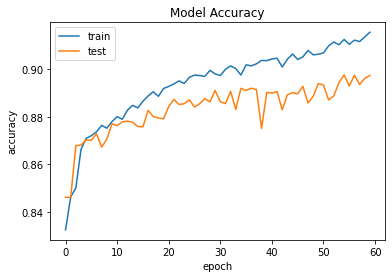

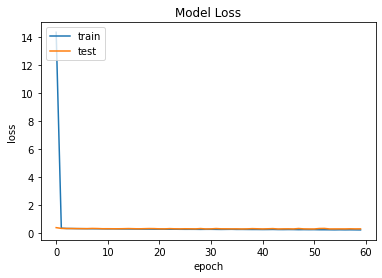

In [ ]:
plot_grp(history_bl_v3)

In [ ]:
history_bl_df = pd.DataFrame(history_bl_v3.history)

In [ ]:
history_bl_df.to_csv('history_bl_df_v3.csv')

In [ ]:
# Evaluate model on test data.
model.evaluate(X_test, y_test, verbose=1)

labels = model.metrics_names

1232/1232 [==============================] - 10s 8ms/step - loss: 0.2845 - accuracy: 0.8974


In [ ]:
preds = model.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

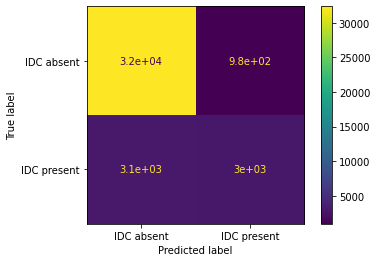

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

#### **Summary Table**


In [ ]:
baseline_mod_v2 = summary_table_1("Model")

In [ ]:
baseline_mod_v2

,model,balanced_accuracy,specificity,recall
0,Model,0.73251,0.97063,0.494389


### **VGG16**

##### Without Image Augmentation

In [ ]:
#### https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f

In [ ]:
import keras 
from keras.applications.vgg16 import VGG16
new_input = Input(shape=(50, 50, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=new_input)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze layers
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Check for frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x) 
vgg_model_v1 = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('vgg16_v1.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
vgg_model_v1.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history_vgg_model_v1 = vgg_model_v1.fit(X_train, y_train, batch_size = 128, epochs=10, steps_per_epoch=300, validation_data=(X_test,y_test), callbacks=[lr_reduce,checkpoint])

Epoch 1/10
300/300 [==============================] - 569s 2s/step - loss: 0.4034 - accuracy: 0.8421 - val_loss: 0.2879 - val_accuracy: 0.8462

Epoch 00001: val_accuracy improved from -inf to 0.84617, saving model to vgg16_v1.h15
INFO:tensorflow:Assets written to: vgg16_v1.h15/assets
Epoch 2/10
300/300 [==============================] - 570s 2s/step - loss: 0.2941 - accuracy: 0.8843 - val_loss: 0.2709 - val_accuracy: 0.8957

Epoch 00002: val_accuracy improved from 0.84617 to 0.89574, saving model to vgg16_v1.h15
INFO:tensorflow:Assets written to: vgg16_v1.h15/assets
Epoch 3/10
300/300 [==============================] - 598s 2s/step - loss: 0.2809 - accuracy: 0.8923 - val_loss: 0.2935 - val_accuracy: 0.8750

Epoch 00003: val_accuracy did not improve from 0.89574
Epoch 4/10
300/300 [==============================] - 602s 2s/step - loss: 0.2596 - accuracy: 0.8994 - val_loss: 0.2598 - val_accuracy: 0.8980

Epoch 00004: val_accuracy improved from 0.89574 to 0.89798, saving model to vgg16_v1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
vgg_model_v1.save('/content/gdrive/My Drive/vgg_model_v1_strat.h5')

In [ ]:
vgg_model_v1 = load_model('/content/gdrive/My Drive/vgg_model_v1.h5')

###### Evaluate Model

In [ ]:
# Evaluate model on test data.
vgg_model_v1.evaluate(X_test, y_test, verbose=1)
labels = vgg_model_v1.metrics_names

1232/1232 [==============================] - 272s 220ms/step - loss: 0.2613 - accuracy: 0.9016


In [ ]:
preds = vgg_model_v1.predict(X_test)
preds_class = np.argmax(preds,axis = 1) 
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

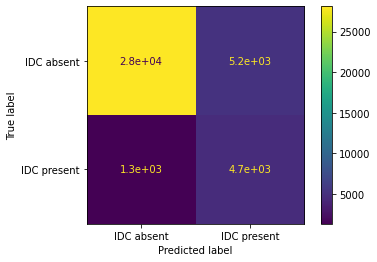

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

######**Summary Table**

In [ ]:
summary_table_1("vgg16 model without image augment")

,model,balanced_accuracy,specificity,recall
0,vgg16 model without image augment,0.80283,0.945429,0.660231


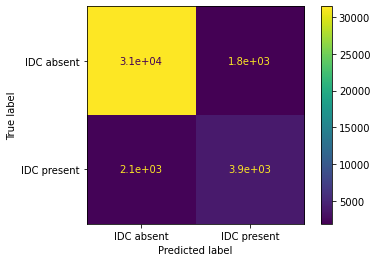

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### With Image Augmentation

In [ ]:
import keras 
from keras.applications.vgg16 import VGG16
new_input = Input(shape=(50, 50, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=new_input)

In [ ]:
# Freeze layers
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Check for frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x) 
vgg_model_v3 = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('vgg16_v3.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=128)
#Fit augmentation to training images
vgg_model_v3.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
#Fit model
history_vgg_v3 = vgg_model_v3.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=10, steps_per_epoch=300, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/10
300/300 [==============================] - 729s 2s/step - loss: 0.2574 - accuracy: 0.8985 - val_loss: 0.2692 - val_accuracy: 0.8905

Epoch 00001: val_accuracy did not improve from 0.89800
Epoch 2/10
300/300 [==============================] - 718s 2s/step - loss: 0.2579 - accuracy: 0.8995 - val_loss: 0.2765 - val_accuracy: 0.8933

Epoch 00002: val_accuracy did not improve from 0.89800
Epoch 3/10
300/300 [==============================] - 694s 2s/step - loss: 0.2514 - accuracy: 0.8999 - val_loss: 0.2453 - val_accuracy: 0.9022

Epoch 00003: val_accuracy improved from 0.89800 to 0.90219, saving model to vgg16_v3.h15
INFO:tensorflow:Assets written to: vgg16_v3.h15/assets
Epoch 4/10
300/300 [==============================] - 725s 2s/step - loss: 0.2508 - accuracy: 0.8989 - val_loss: 0.2500 - val_accuracy: 0.9023

Epoch 00004: val_accuracy improved from 0.90219 to 0.90232, saving model to vgg16_v3.h15
INFO:tensorflow:Assets written to: vgg16_v3.h15/assets
Epoch 5/10
300/300 [======

In [ ]:
vgg_model_v3.save('/content/gdrive/My Drive/vgg_model_v3_strat.h5')

###### Evaluate Model

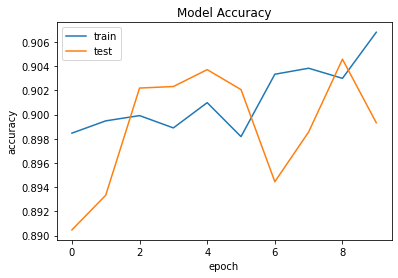

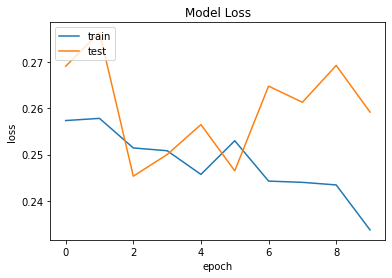

In [ ]:
plot_grp(history_vgg_v3)

Image augmentation did not result in improvement to model accuracy. 

In [ ]:
history_vgg_v3_df = pd.DataFrame(history_vgg_v3.history)

In [ ]:
history_vgg_v3_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.257382,0.898464,0.269162,0.890463,0.00005
1,0.257855,0.899479,0.276538,0.893331,0.00005
2,0.251442,0.899914,0.245319,0.902191,0.00005
3,0.250836,0.898896,0.250008,0.902318,0.00005
4,0.245699,0.900984,0.256505,0.903714,0.00005
5,0.253003,0.898177,0.246476,0.902064,0.00005
6,0.244249,0.903333,0.264854,0.894448,0.00005
7,0.243976,0.903830,0.261350,0.898561,0.00005
8,0.243419,0.902995,0.269338,0.904577,0.00005
9,0.233659,0.906806,0.259218,0.899322,0.00005


In [ ]:
history_vgg_v3_df.to_csv('/content/gdrive/My Drive/history_vgg_v3_df.csv')

In [ ]:
# Evaluate model on test data.
vgg_model_v3.evaluate(X_test, y_test, verbose=1)

labels = vgg_model_v3.metrics_names

1232/1232 [==============================] - 232s 189ms/step - loss: 0.2592 - accuracy: 0.8993


In [ ]:
preds = vgg_model_v3.predict(X_test)
preds_class = np.argmax(preds,axis = 1) 
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

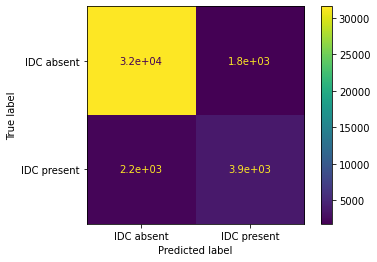

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

######**Summary Table**


In [ ]:
summary_table_1("vgg16 model with image augmentation")

,model,balanced_accuracy,specificity,recall
0,vgg16 model with image augmentation,0.792329,0.946869,0.637789


### **ResNet**

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

#### Without Image Augmentation

In [ ]:
new_input = Input(shape=(50, 50, 3))
resnet50_model = ResNet50(weights= 'imagenet', pooling = "max", include_top=False, input_tensor=new_input)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze layers
for layer in resnet50_model.layers[:175]:
    layer.trainable = False
# Check for frozen the correct layers
for i, layer in enumerate(resnet50_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
x = resnet50_model.output
x = tf.keras.layers.Flatten()(x) # Flatten dimensions
x = tf.keras.layers.Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = tf.keras.layers.Dense(2, activation='sigmoid')(x) 
resnet50_model_v1 = Model(inputs=resnet50_model.input, outputs=x)

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('resnet_v1.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
resnet50_model_v1.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history_resnet50_model_v1 = resnet50_model_v1.fit(X_train, y_train, batch_size = 128, epochs=30, steps_per_epoch=200, validation_data=(X_test,y_test), callbacks=[lr_reduce,checkpoint])

Epoch 1/30
200/200 [==============================] - 217s 1s/step - loss: 1.0886 - accuracy: 0.7249 - val_loss: 0.5391 - val_accuracy: 0.8482

Epoch 00001: val_accuracy improved from -inf to 0.84825, saving model to resnet_v1.h15
INFO:tensorflow:Assets written to: resnet_v1.h15/assets
Epoch 2/30
200/200 [==============================] - 220s 1s/step - loss: 0.7655 - accuracy: 0.8276 - val_loss: 0.4618 - val_accuracy: 0.8662

Epoch 00002: val_accuracy improved from 0.84825 to 0.86619, saving model to resnet_v1.h15
INFO:tensorflow:Assets written to: resnet_v1.h15/assets
Epoch 3/30
200/200 [==============================] - 221s 1s/step - loss: 0.6774 - accuracy: 0.8441 - val_loss: 0.4406 - val_accuracy: 0.8715

Epoch 00003: val_accuracy improved from 0.86619 to 0.87147, saving model to resnet_v1.h15
INFO:tensorflow:Assets written to: resnet_v1.h15/assets
Epoch 4/30
200/200 [==============================] - 221s 1s/step - loss: 0.6290 - accuracy: 0.8532 - val_loss: 0.4170 - val_accurac

In [ ]:
# resnet50_model_v1.save('/content/gdrive/My Drive/resnet50_model_v1.h5')

In [ ]:
resnet50_model_v1.save('/content/gdrive/My Drive/resnet50_model_v1_strat.h5')

###### Evaluate Model

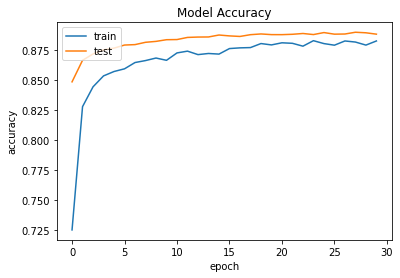

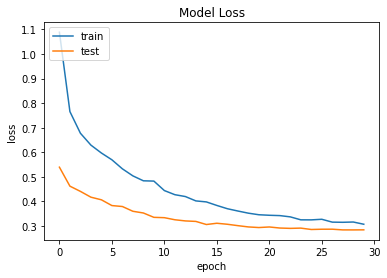

In [ ]:
plot_grp(history_resnet50_model_v1)

In [ ]:
history_resnet50_model_v1_df = pd.DataFrame(history_resnet50_model_v1.history)

In [ ]:
history_resnet50_model_v1_df.to_csv('history_resnet50_model_v1_strat_df.csv')

In [ ]:
# Evaluate model on test data.
resnet50_model_v1.evaluate(X_test, y_test, verbose=1)

labels = resnet50_model_v1.metrics_names

1232/1232 [==============================] - 213s 173ms/step - loss: 0.2840 - accuracy: 0.8880


In [ ]:
preds = resnet50_model_v1.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

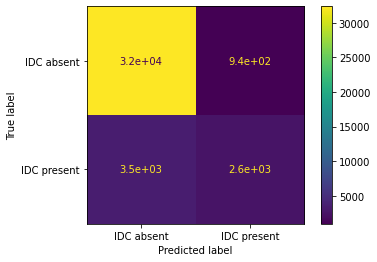

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
resnet50_v1_1 = summary_table_1("resnet model without image augmentation")

In [ ]:
resnet50_v1_1

,model,balanced_accuracy,specificity,recall
0,resnet model without image augmentation,0.699551,0.97171,0.427393


#### With Image Augmentation

In [ ]:
new_input = Input(shape=(50, 50, 3))
resnet50_model = ResNet50(weights= 'imagenet', pooling = "max", include_top=False, input_tensor=new_input)

In [ ]:
# Freeze layers
for layer in resnet50_model.layers[:175]:
    layer.trainable = False
# Check for frozen the correct layers
for i, layer in enumerate(resnet50_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
x = resnet50_model.output
x = tf.keras.layers.Flatten()(x) # Flatten dimensions
x = tf.keras.layers.Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = tf.keras.layers.Dense(2, activation='sigmoid')(x) 
resnet50_model_v2 = Model(inputs=resnet50_model.input, outputs=x)

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('resnet_v2.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=128)
#Fit augmentation to training images
resnet50_model_v2.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
#Fit model
history_resnet50_model_v2 = resnet50_model_v2.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=15, steps_per_epoch=300, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/15
300/300 [==============================] - 310s 1s/step - loss: 0.8078 - accuracy: 0.8200 - val_loss: 0.4487 - val_accuracy: 0.8611

Epoch 00001: val_accuracy improved from -inf to 0.86114, saving model to resnet_v2.h15
INFO:tensorflow:Assets written to: resnet_v2.h15/assets
Epoch 2/15
300/300 [==============================] - 306s 1s/step - loss: 0.6532 - accuracy: 0.8465 - val_loss: 0.4067 - val_accuracy: 0.8688

Epoch 00002: val_accuracy improved from 0.86114 to 0.86881, saving model to resnet_v2.h15
INFO:tensorflow:Assets written to: resnet_v2.h15/assets
Epoch 3/15
300/300 [==============================] - 310s 1s/step - loss: 0.5970 - accuracy: 0.8510 - val_loss: 0.3868 - val_accuracy: 0.8721

Epoch 00003: val_accuracy improved from 0.86881 to 0.87213, saving model to resnet_v2.h15
INFO:tensorflow:Assets written to: resnet_v2.h15/assets
Epoch 4/15
300/300 [==============================] - 308s 1s/step - loss: 0.5493 - accuracy: 0.8564 - val_loss: 0.3656 - val_accurac

In [ ]:
resnet50_model_v2.save('/content/gdrive/My Drive/resnet50_model_v2_strat.h5')

###### Evaluate Model

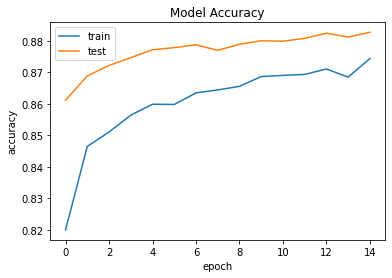

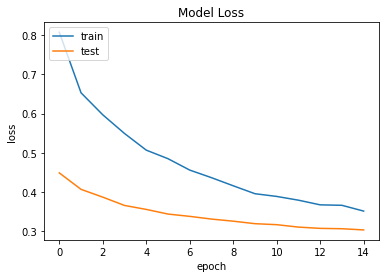

In [ ]:
plot_grp(history_resnet50_model_v2)

In [ ]:
history_resnet50_model_v2_df = pd.DataFrame(history_resnet50_model_v2.history)

In [ ]:
history_resnet50_model_v2_df.to_csv('history_resnet50_model_v2_df.csv')

In [ ]:
# Evaluate model on test data.
resnet50_model_v2.evaluate(X_test, y_test, verbose=1)

labels = resnet50_model_v2.metrics_names

1232/1232 [==============================] - 184s 149ms/step - loss: 0.3032 - accuracy: 0.8827


In [ ]:
preds = resnet50_model_v2.predict(X_test)
preds_class = np.argmax(preds,axis = 1) 
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

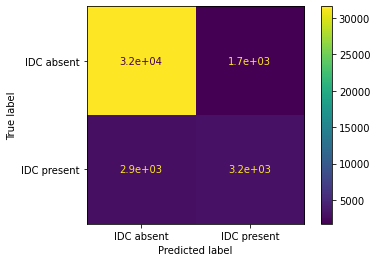

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
resnet50_v2_1 = summary_table_1("resnet model with image augmentation")
resnet50_v2_1

,model,balanced_accuracy,specificity,recall
0,resnet model with image augmentation,0.734626,0.948459,0.520792


### **Custom Model**

#### Without Image Augmentation

In [ ]:
model_v2=Sequential()
model_v2.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2.add(MaxPool2D(pool_size=(2,2)))

model_v2.add(MaxPool2D(pool_size=(2,2)))
model_v2.add(Dropout(0.25))

model_v2.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2.add(MaxPool2D(pool_size=(2,2)))

model_v2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2.add(Dropout(0.25))

model_v2.add(Flatten())

model_v2.add(Dense(128,activation='relu'))
model_v2.add(Dense(64,activation='relu'))
model_v2.add(Dense(2,activation='sigmoid'))

model_v2.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= ['accuracy'])


model_v2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
history_v2 = model_v2.fit(
    X_train, 
    y_train, 
    batch_size = 512, epochs=30, 
    steps_per_epoch=200, 
    validation_data=(X_test,y_test), 
    callbacks=[lr_reduce,checkpoint])

Epoch 1/30
200/200 [==============================] - 56s 278ms/step - loss: 1.3470 - accuracy: 0.8396 - val_loss: 0.5022 - val_accuracy: 0.8118

Epoch 00001: val_accuracy improved from -inf to 0.81182, saving model to model_v2.h15
INFO:tensorflow:Assets written to: model_v2.h15/assets
Epoch 2/30
200/200 [==============================] - 55s 274ms/step - loss: 0.3283 - accuracy: 0.8580 - val_loss: 0.4751 - val_accuracy: 0.7934

Epoch 00002: val_accuracy did not improve from 0.81182
Epoch 3/30
200/200 [==============================] - 54s 272ms/step - loss: 0.3177 - accuracy: 0.8633 - val_loss: 0.3990 - val_accuracy: 0.8530

Epoch 00003: val_accuracy improved from 0.81182 to 0.85299, saving model to model_v2.h15
INFO:tensorflow:Assets written to: model_v2.h15/assets
Epoch 4/30
200/200 [==============================] - 55s 275ms/step - loss: 0.3127 - accuracy: 0.8667 - val_loss: 0.3578 - val_accuracy: 0.8648

Epoch 00004: val_accuracy improved from 0.85299 to 0.86477, saving model to 

In [ ]:
model_v2.save('/content/gdrive/My Drive/model_v2_strat.h5')

##### Evaluate Model

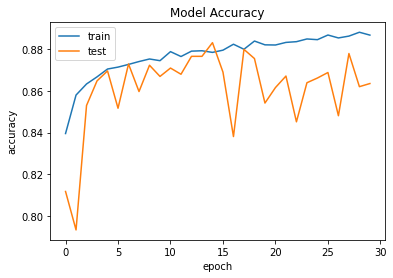

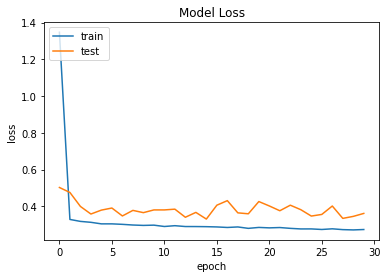

In [ ]:
plot_grp(history_v2)

In [ ]:
history_model_v2_df = pd.DataFrame(history_v2.history)

In [ ]:
history_model_v2_df.to_csv('history_model_v2.csv')

In [ ]:
# Evaluate model on test data.
model_v2.evaluate(X_test, y_test, verbose=1)

labels = model_v2.metrics_names

1232/1232 [==============================] - 14s 11ms/step - loss: 0.3611 - accuracy: 0.8635


In [ ]:
preds = model_v2.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

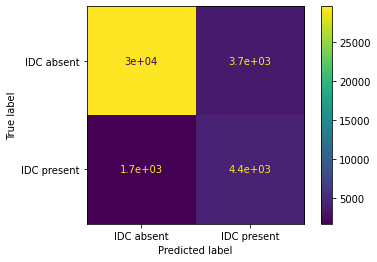

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**



In [ ]:
model_v2_t2 = summary_table_1("model without image augmentation")
model_v2_t2 

,model,balanced_accuracy,specificity,recall
0,model without image augmentation,0.805593,0.889239,0.721947


#### With Image Augmentation

In [ ]:
model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(128,activation='relu'))
model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 32)         

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 114s 565ms/step - loss: 0.5518 - accuracy: 0.8493 - val_loss: 0.4847 - val_accuracy: 0.8036

Epoch 00001: val_accuracy improved from -inf to 0.80362, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 113s 565ms/step - loss: 0.3122 - accuracy: 0.8678 - val_loss: 0.4101 - val_accuracy: 0.8439

Epoch 00002: val_accuracy improved from 0.80362 to 0.84393, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 3/30
200/200 [==============================] - 114s 570ms/step - loss: 0.3073 - accuracy: 0.8701 - val_loss: 0.4216 - val_accuracy: 0.8315

Epoch 00003: val_accuracy did not improve from 0.84393
Epoch 4/30
200/200 [==============================] - 114s 567ms/step - loss: 0.3046 - accuracy: 0.8728 - val_loss: 0.4904 - val_accuracy: 0.7680

Epoch 00004: val_accuracy did not improve from 0.84393
Epoch 5/3

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat.h5')

##### Evaluate Model

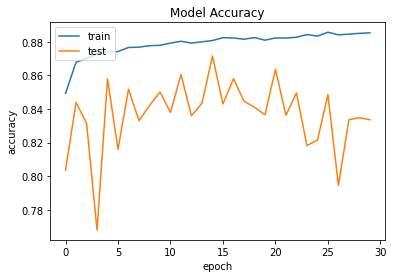

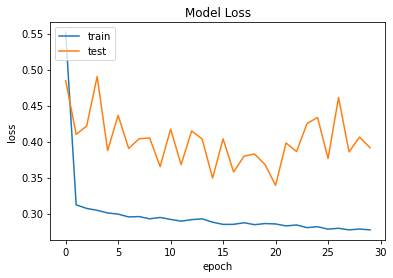

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 13s 10ms/step - loss: 0.3915 - accuracy: 0.8336


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

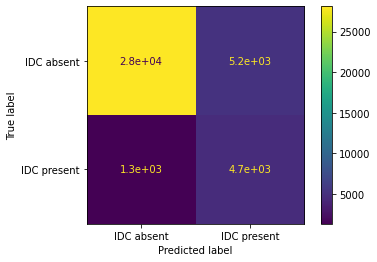

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation,0.812226,0.843098,0.781353


In view that the previous image augmented model provided the best Balanced Accuracy Score and reasonably higher Recall and Specificity scores, we will fine tune this model accordingly.  As can be seen in the graph mapping out test loss and accuracy, it is noted that the test loss and accuracy fluctuated often. In addition, the test accuracy appears lower than the train accuracy, suggesting that there may be some extent of overfitting. 

### **With Image Augmentation (v2)**

In version 2, we attempt to regularize by increasing dropouts layers to 0.5. 

In [ ]:
## Try 0.5 Dropout

model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(128,activation='relu'))
model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 111s 547ms/step - loss: 1.4674 - accuracy: 0.8369 - val_loss: 0.5662 - val_accuracy: 0.8462

Epoch 00001: val_accuracy improved from -inf to 0.84617, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 110s 550ms/step - loss: 0.3348 - accuracy: 0.8496 - val_loss: 0.5831 - val_accuracy: 0.7267

Epoch 00002: val_accuracy did not improve from 0.84617
Epoch 3/30
200/200 [==============================] - 109s 545ms/step - loss: 0.3230 - accuracy: 0.8611 - val_loss: 0.6088 - val_accuracy: 0.6934

Epoch 00003: val_accuracy did not improve from 0.84617
Epoch 4/30
200/200 [==============================] - 109s 546ms/step - loss: 0.3162 - accuracy: 0.8648 - val_loss: 0.6042 - val_accuracy: 0.7278

Epoch 00004: val_accuracy did not improve from 0.84617
Epoch 5/30
200/200 [==============================] - 111s 554ms/step - loss: 0.3115 - accuracy: 0.868

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_dropout.h5')

##### Evaluate Model

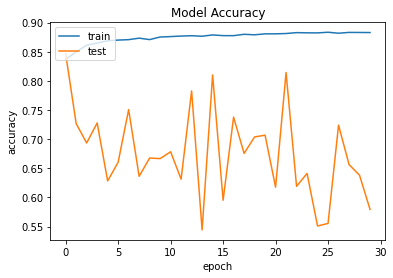

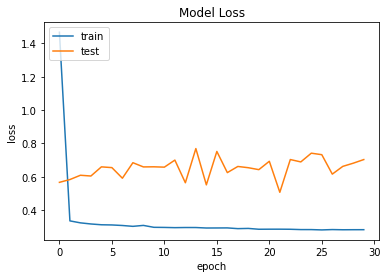

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 8s 7ms/step - loss: 0.7030 - accuracy: 0.5795


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

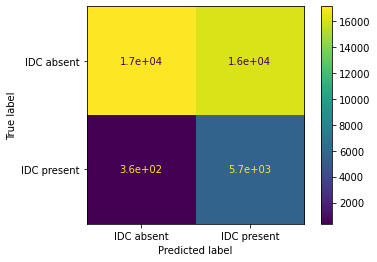

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5),0.727017,0.513935,0.940099


Increasing dropouts to 0.5 was not ideal. It led to an estimated 9% decrease in balanced accuracy as well as a dip in specificity score.  Nevertheless, recall scores improved to 94%. 

### **With Image Augmentation (v3)**


In version 3, we attempt to regularize by increasing dropouts layers to 0.5 and 0.25 respectively. 

In [ ]:
## Try 0.5 Dropout at the end and 0.25 dropout at the start

model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(128,activation='relu'))
model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 32)         

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 111s 554ms/step - loss: 0.9960 - accuracy: 0.8356 - val_loss: 0.5138 - val_accuracy: 0.8462

Epoch 00001: val_accuracy improved from -inf to 0.84617, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 110s 552ms/step - loss: 0.3236 - accuracy: 0.8620 - val_loss: 0.4356 - val_accuracy: 0.8421

Epoch 00002: val_accuracy did not improve from 0.84617
Epoch 3/30
200/200 [==============================] - 110s 551ms/step - loss: 0.3262 - accuracy: 0.8666 - val_loss: 0.4897 - val_accuracy: 0.8321

Epoch 00003: val_accuracy did not improve from 0.84617
Epoch 4/30
200/200 [==============================] - 111s 553ms/step - loss: 0.3101 - accuracy: 0.8715 - val_loss: 0.4667 - val_accuracy: 0.8428

Epoch 00004: val_accuracy did not improve from 0.84617
Epoch 5/30
200/200 [==============================] - 110s 550ms/step - loss: 0.3093 - accuracy: 0.871

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_dropout_v2.h5')

##### Evaluate Model

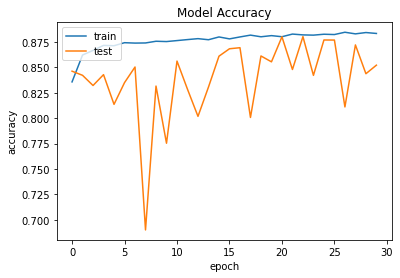

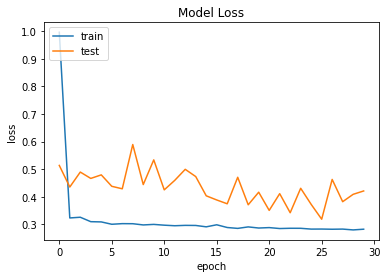

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 10s 8ms/step - loss: 0.4200 - accuracy: 0.8524


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

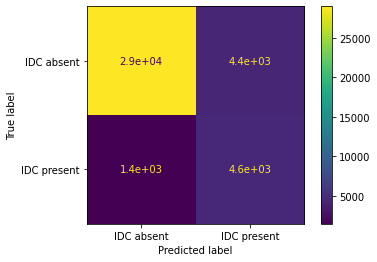

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
model_v2_i_t = summary_table("model with image augmentation (dropout = 0.5 and 0.25)")
model_v2_i_t

,model,balanced_accuracy,accuracy,specificity,recall,precision,f1_score
0,model with image augmentation (dropout = 0.5 a...,0.815037,0.85241,0.869019,0.761056,0.5137,0.613379


In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5 and 0.25)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5 a...,0.815037,0.869019,0.761056


A dropout rate of 0.25 for the first dropout layer and subsequently 0.5 for the second dropout allowed for higher balanced accuracy and specificity score. 

### **With Image Augmentation (v4)**


In version 4, we attempt to conduct batch normalization. 

Batch normalization is a technique that automatically standardizes the inputs to a layer in a neural network.Batch normalization may improve the training process and at times, improve the performance of the model via a modest regularization effect.

In [ ]:
## Batch regularization

model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(BatchNormalization())

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(128,activation='relu'))
model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 32)         

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 113s 563ms/step - loss: 0.3246 - accuracy: 0.8632 - val_loss: 0.6445 - val_accuracy: 0.5538

Epoch 00001: val_accuracy improved from -inf to 0.55375, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 112s 559ms/step - loss: 0.2964 - accuracy: 0.8768 - val_loss: 0.6164 - val_accuracy: 0.6547

Epoch 00002: val_accuracy improved from 0.55375 to 0.65474, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 3/30
200/200 [==============================] - 111s 556ms/step - loss: 0.2897 - accuracy: 0.8801 - val_loss: 0.3380 - val_accuracy: 0.8793

Epoch 00003: val_accuracy improved from 0.65474 to 0.87929, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 4/30
200/200 [==============================] - 112s 560ms/step - loss: 0.2852 - accuracy: 0.8828 - val_loss: 0.

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_bn_v3.h5')

##### Evaluate Model

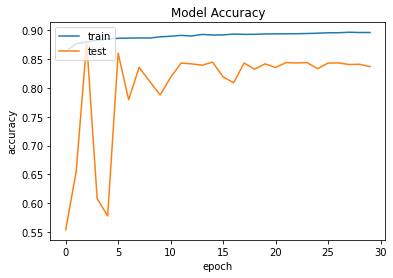

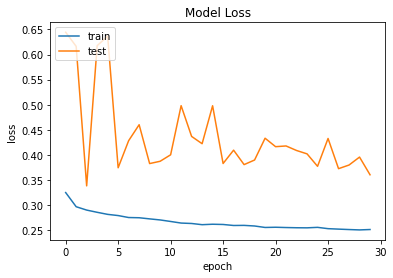

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 9s 7ms/step - loss: 0.3601 - accuracy: 0.8370


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

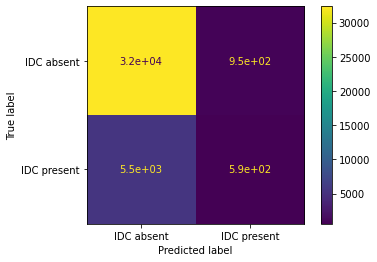

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5 and 0.25 and batch norm)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5 a...,0.5347,0.97138,0.0980198


From the drop in balanced accuracy score and recall score, batch normalization is noted to perform poorly on the model. 

### **With Image Augmentation (v5)**

In version 5, we attempt to remove 1 layer to see the model's performance.

In [ ]:
## 1 layer

model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 2, 2, 32)         

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 112s 554ms/step - loss: 1.8255 - accuracy: 0.8125 - val_loss: 0.5252 - val_accuracy: 0.8447

Epoch 00001: val_accuracy improved from -inf to 0.84474, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 111s 555ms/step - loss: 0.3518 - accuracy: 0.8444 - val_loss: 0.5291 - val_accuracy: 0.8456

Epoch 00002: val_accuracy improved from 0.84474 to 0.84556, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 3/30
200/200 [==============================] - 112s 557ms/step - loss: 0.3297 - accuracy: 0.8451 - val_loss: 0.3702 - val_accuracy: 0.8461

Epoch 00003: val_accuracy improved from 0.84556 to 0.84614, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 4/30
200/200 [==============================] - 111s 552ms/step - loss: 0.3252 - accuracy: 0.8457 - val_loss: 0.

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_v5.h5')

##### Evaluate Model

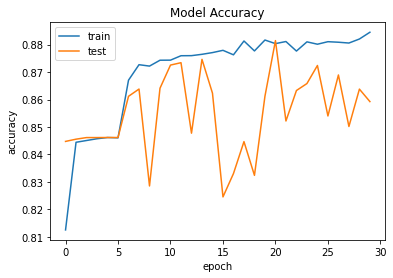

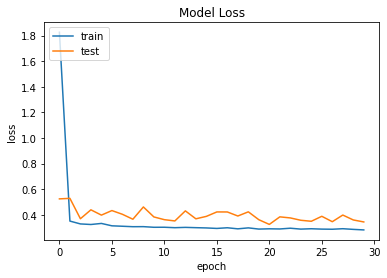

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 9s 7ms/step - loss: 0.3451 - accuracy: 0.8592


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

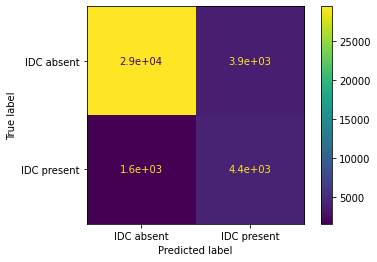

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5 and 0.25, 2 layers)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5 a...,0.806718,0.882579,0.730858


### **With Image Augmentation (v6)**



In version 6, we use 3 connecting dense layers of 32, 16 and 2 neurons respectively.

In [ ]:
model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(32,activation='relu'))
model_v2_i.add(Dense(16,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 2, 2, 32)         

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 111s 552ms/step - loss: 0.6517 - accuracy: 0.8361 - val_loss: 0.5316 - val_accuracy: 0.8462

Epoch 00001: val_accuracy improved from -inf to 0.84617, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 110s 552ms/step - loss: 0.3407 - accuracy: 0.8451 - val_loss: 0.3824 - val_accuracy: 0.8462

Epoch 00002: val_accuracy did not improve from 0.84617
Epoch 3/30
200/200 [==============================] - 110s 550ms/step - loss: 0.3265 - accuracy: 0.8465 - val_loss: 0.4450 - val_accuracy: 0.8462

Epoch 00003: val_accuracy did not improve from 0.84617
Epoch 4/30
200/200 [==============================] - 111s 552ms/step - loss: 0.3207 - accuracy: 0.8487 - val_loss: 0.3447 - val_accuracy: 0.8733

Epoch 00004: val_accuracy improved from 0.84617 to 0.87333, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 5/3

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_v6.h5')

##### Evaluate Model

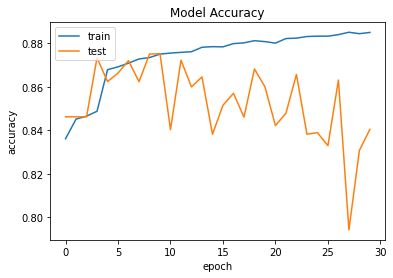

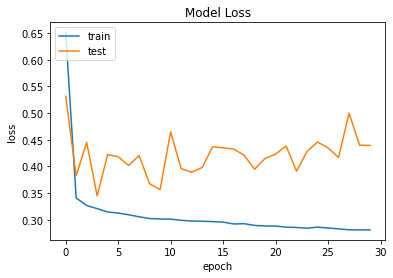

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 8s 7ms/step - loss: 0.4392 - accuracy: 0.8404


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

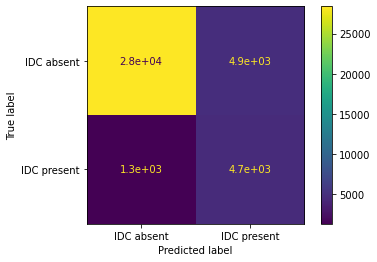

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5 and 0.25, 3 dense layers - 32, 16, 2)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5 a...,0.814708,0.851859,0.777558


### **With Image Augmentation (v7)**



In version 7, we use 3 connecting dense layers of 64, 32 and 2 neurons respectively.

In [ ]:
model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(32,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 2, 32)         

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 111s 551ms/step - loss: 1.0726 - accuracy: 0.8369 - val_loss: 0.5046 - val_accuracy: 0.8461

Epoch 00001: val_accuracy improved from -inf to 0.84614, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 113s 563ms/step - loss: 0.3413 - accuracy: 0.8460 - val_loss: 0.4730 - val_accuracy: 0.8462

Epoch 00002: val_accuracy improved from 0.84614 to 0.84617, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 3/30
200/200 [==============================] - 112s 561ms/step - loss: 0.3223 - accuracy: 0.8502 - val_loss: 0.4107 - val_accuracy: 0.8627

Epoch 00003: val_accuracy improved from 0.84617 to 0.86269, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 4/30
200/200 [==============================] - 111s 554ms/step - loss: 0.3135 - accuracy: 0.8682 - val_loss: 0.

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_v7.h5')

##### Evaluate Model

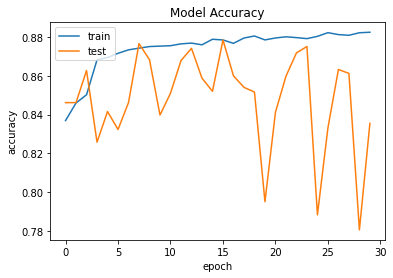

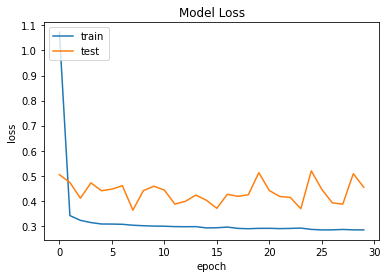

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 8s 7ms/step - loss: 0.4541 - accuracy: 0.8355


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

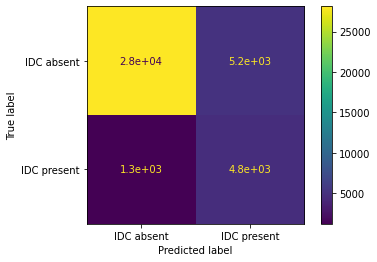

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5 and 0.25, 3 dense layers - 64, 32, 2)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5 a...,0.814708,0.851859,0.777558


### **With Image Augmentation (v8)**



In version 8, we will have 4 connected dense layers with 128, 64 and 32 and then an ouput layer

In [ ]:
## 4 layers - 128, 64, 32

model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(128,activation='relu'))
model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(16,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 108s 535ms/step - loss: 0.4733 - accuracy: 0.8452 - val_loss: 0.5152 - val_accuracy: 0.8251

Epoch 00001: val_accuracy improved from -inf to 0.82510, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 108s 539ms/step - loss: 0.3205 - accuracy: 0.8616 - val_loss: 0.4932 - val_accuracy: 0.8227

Epoch 00002: val_accuracy did not improve from 0.82510
Epoch 3/30
200/200 [==============================] - 106s 532ms/step - loss: 0.3138 - accuracy: 0.8675 - val_loss: 0.4764 - val_accuracy: 0.8045

Epoch 00003: val_accuracy did not improve from 0.82510
Epoch 4/30
200/200 [==============================] - 106s 531ms/step - loss: 0.3099 - accuracy: 0.8707 - val_loss: 0.3995 - val_accuracy: 0.8591

Epoch 00004: val_accuracy improved from 0.82510 to 0.85911, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 5/3

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_v8.h5')

##### Evaluate Model

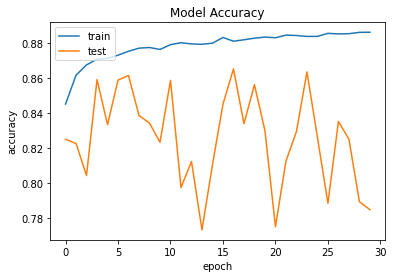

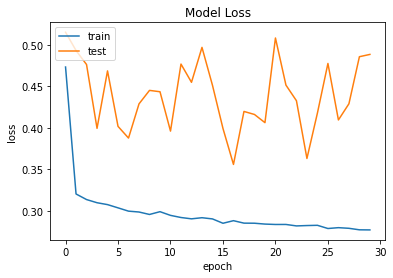

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 8s 7ms/step - loss: 0.4885 - accuracy: 0.7850


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

array([[25909,  7424],
       [ 1045,  5015]])

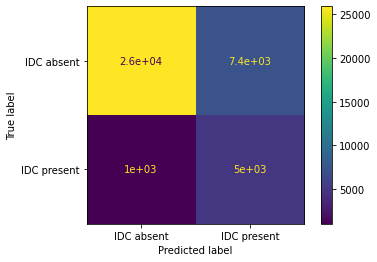

array([[25909,  7424],
       [ 1045,  5015]])

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()
cm

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5 and 0.25, 3 dense layers - 128, 64, 32, 2)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5 a...,0.802418,0.777278,0.827558


Model v8 saw improved recall scores. However, the number of false positives was much larger at 7400. For this project, attaining a lower number of false negatives is of a higher priority than attaining a lower number of false positives as we rationalise that it is more important for IDC-positive patches to be correctly identified.  Misclassifying IDC-positive patches will have more significant consequences than misclassifying normal patches.  Misclassified normal patches can be relooked again by pathologist to determine if it is normal or IDC-positive. However, it would be much more effortful to look through batches of normal scans for IDC-positive patches.   

That being said, the number of false positives in this model is higher than the previous few models and would be slightly concerning. 

### **With Image Augmentation (v9)**



In version 9, we will add batch normalization after a convulational layer.

In [ ]:
## Add Batch normalization

model_v2_i=Sequential()
model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2)))
model_v2_i.add(Dropout(0.25))

model_v2_i.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model_v2_i.add(BatchNormalization())
model_v2_i.add(MaxPool2D(pool_size=(2,2)))

model_v2_i.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_v2_i.add(Dropout(0.5))

model_v2_i.add(Flatten())

model_v2_i.add(Dense(128,activation='relu'))
model_v2_i.add(Dense(64,activation='relu'))
model_v2_i.add(Dense(2,activation='sigmoid'))

model_v2_i.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 47, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          16416     
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 32)         1

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Patience is set as 8 epochs.  After 8 epochs, and no improvement, learning rate will be reduced.
# min_lower bound on the learning rate set to 5e-5.
checkpoint = ModelCheckpoint('model_v2_i.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=512)
#Fit augmentation to training images
model_v2_i.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
#Fit model
history_model_v2_i = model_v2_i.fit_generator(train_generator, validation_data=(X_test,y_test), epochs=30, steps_per_epoch=200, shuffle=True, callbacks=[lr_reduce, checkpoint],verbose=1)

Epoch 1/30
200/200 [==============================] - 109s 538ms/step - loss: 0.3446 - accuracy: 0.8600 - val_loss: 0.3855 - val_accuracy: 0.8687

Epoch 00001: val_accuracy improved from -inf to 0.86871, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 2/30
200/200 [==============================] - 108s 539ms/step - loss: 0.3024 - accuracy: 0.8752 - val_loss: 0.5484 - val_accuracy: 0.7290

Epoch 00002: val_accuracy did not improve from 0.86871
Epoch 3/30
200/200 [==============================] - 108s 540ms/step - loss: 0.2967 - accuracy: 0.8777 - val_loss: 0.3870 - val_accuracy: 0.8446

Epoch 00003: val_accuracy did not improve from 0.86871
Epoch 4/30
200/200 [==============================] - 108s 540ms/step - loss: 0.2886 - accuracy: 0.8809 - val_loss: 0.3121 - val_accuracy: 0.8816

Epoch 00004: val_accuracy improved from 0.86871 to 0.88160, saving model to model_v2_i.h15
INFO:tensorflow:Assets written to: model_v2_i.h15/assets
Epoch 5/3

In [ ]:
model_v2_i.save('/content/gdrive/My Drive/model_v2_i_strat_v9.h5')

##### Evaluate Model

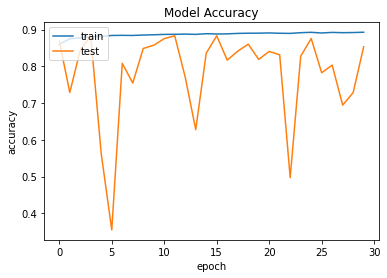

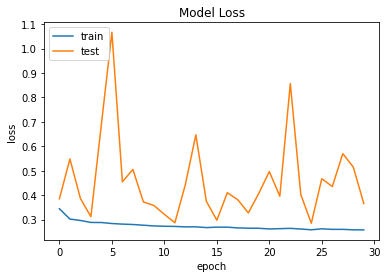

In [ ]:
plot_grp(history_model_v2_i)

In [ ]:
history_model_v2_i_df = pd.DataFrame(history_model_v2_i.history)

In [ ]:
history_model_v2_i_df.to_csv('history_model_v2_i.csv')

In [ ]:
# Evaluate model on test data.
model_v2_i.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 8s 7ms/step - loss: 0.3662 - accuracy: 0.8533


In [ ]:
preds = model_v2_i.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

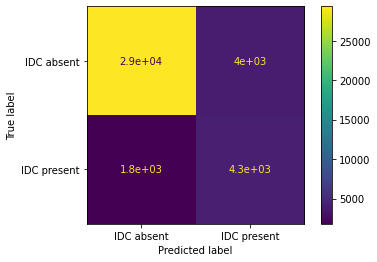

array([[29349,  3984],
       [ 1794,  4266]])

In [ ]:
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()
cm

##### **Summary Table**

In [ ]:
model_v2_i_t_1 = summary_table_1("model with image augmentation (dropout = 0.5 and 0.25, 2 dense layers - 128, 64, 2, bm)")
model_v2_i_t_1

,model,balanced_accuracy,specificity,recall
0,model with image augmentation (dropout = 0.5 a...,0.79222,0.880479,0.70396


# **Model Evaluation**


The classification model chosen had a twofold objective to 1) reduce the number of false negatives (optimal recall score) and 2) attain a higher Balanced Accuracy Score.  

Balanced Accuracy Score is a more meaningful evaluation metrics as compared to just accuracy score.  It is the average of the proportion correctly classified of each class individually. 

In the case of breast cancer, it is imperative that we minimise false negative as incorrectly predicting ‘no IDC presence’ when there is IDC will have serious consequences, hence recall score is something we wanted to focus on.

Specificity measures a test's ability to correctly generate a negative result for image patches that don't have the IDC.

Interestingly, dataset performed better on models with fewer layers like this one. It performed especially poorly on recall on Resnet50 and our baseline model. 

Although the baseline and ResNet50 model achieved a specificity score of 0.97, the corresponding balanced accuracy and recall scores were low and thus, was not selected as a chosen model. 

The chosen custom model had highest balanced accuracy (0.815) and recall (0.761) score.  


|Model|Balanced Accuracy|Specificity|Recall|
|------------------------|-------|-------|-------|
|Baseline Model|0.73251|0.97063|0.494389|
|Vgg16 model without image augment|0.80283|0.945429|0.660231|
|Vgg16 model with image augmentation|0.792329|0.946869|0.637789|
|ResNet50 model without image augmentation|0.699551|0.97171|0.427393|
|ResNet50 model with image augmentation|0.734626|0.948459|0.520792|
|Model without image augmentation|0.805593|0.889239|0.721947|
|Model with image augmentation|0.815037|0.869019|0.761056|


The custom model with image augmentation v3 provided us the best recall and balanced accuracy score as compared to the other pre-trained models. 


|Model Versions|Image Augmentation|Dropout Layer Value|Hidden Layer Node|Batch Normalization|Balanced Accuracy|Specificity|Recall|Remarks|
|--------|--------|--------|--------|--------|--------|--------|--------|-----------------|
|v0|No|[0.25,0.25]|[128,64,2]|No|0.805593|0.889239|0.721947||
|v1|Yes|[0.25,0.25]|[128,64,2]|No|0.812226|0.843098|0.781353||
|v2|Yes|[0.5,0.5]|[128,64,2]|No|0.727017|0.513935|0.940099|Not chosen, larger number of false positives.|
|v3|Yes|[0.25,0.5]|[128,64,2]|No|0.815037|0.869019|0.761056|Chosen model|
|v4|Yes|[0.25,0.5]|[128,64,2]|Yes (after conv 2)|0.5347|0.97138|0.0980198||
|v5|Yes|[0.25,0.5]|[64,2]|No|0.806718|0.882579|0.730858||
|v6|Yes|[0.25,0.5]|[32,16,2]|No|0.814708|0.851859|0.777558|Not chosen, larger number of false positives.|
|v7|Yes|[0.25,0.5]|[64,32]|No|0.818196|0.843158|0.793234|Not chosen, larger number of false positives|
|v8|Yes|[0.25,0.5]|[128,64,32,2]|No|0.802418|0.777278|0.827558||
|v9|Yes|[0.25,0.5]|[128,64,2]|Yes (before pooling)|0.79222|0.880479|0.70396||

#**Best Model**

The best model appears to be a non-pretrained model enhanced with image augmentation, with dropout layer values of [0.25, 0.5] and hidden layer nodes of [128, 64, 2]. No batch normalization was done. 




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load best model
best_model = load_model('/content/gdrive/MyDrive/model_v2_i_strat_dropout_v2.h5')

In [ ]:
# Best model summary
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 47, 47, 32)        1568      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 11, 11, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          16416     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 32)        

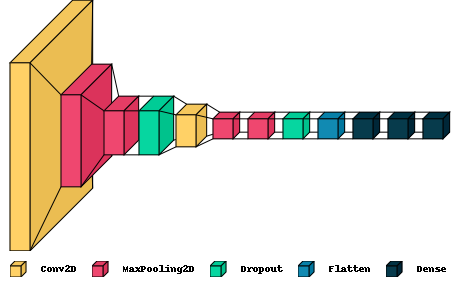

In [ ]:
# Visualise model
! pip install visualkeras
import visualkeras

model_dis = best_model

visualkeras.layered_view(model_dis).show() # display using your system viewer
visualkeras.layered_view(model_dis, to_file='output.png') # write to disk
visualkeras.layered_view(model_dis, to_file='output.png').show() # write and show

visualkeras.layered_view(model_dis, spacing=15, legend=True)

This figure is generated by adapting the code from [link](https://github.com/gwding/draw_convnet).

In [ ]:
summary_table_1(best_model)

,model,balanced_accuracy,specificity,recall
0,<keras.engine.sequential.Sequential object at ...,0.815037,0.869019,0.761056


In [ ]:
# Evaluate model on test data.
best_model.evaluate(X_test, y_test, verbose=1)

labels = model_v2_i.metrics_names

1232/1232 [==============================] - 11s 9ms/step - loss: 0.4200 - accuracy: 0.8524


In [ ]:
# Predict class from test dataset
preds = best_model.predict(X_test)
preds_class = np.argmax(preds,axis = 1)
actual_class = np.argmax(y_test,axis = 1)
tn, fp, fn, tp = confusion_matrix(actual_class, preds_class).ravel()

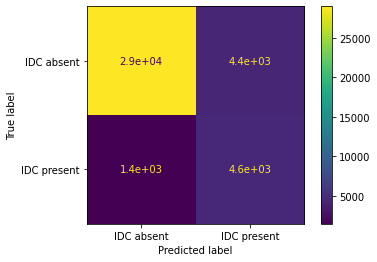

array([[28967,  4366],
       [ 1448,  4612]])

In [ ]:
# Create confusion matrix
cm = confusion_matrix(actual_class, preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["IDC absent","IDC present"])
disp.plot()
plt.show()
cm

A confusion matrix was created to examine the breakdown between actual and predicted classes. The model correctly predicted 28967 IDC-absent image patches and 4612 IDC-present image patches. 
It wrongly classifies just 1,448 IDC-present image as normal patches (1,448) - a relatively higher number as compared to the other models. 
The number of false negative is 4366. Though the number of false negative is a larger number, we will accept this model as attaining a lower number of false negatives is of a higher priority than attaining a lower number of false positives.  As mentioned previously, it is more important for IDC-positive patches to be correctly identified. Misclassifying IDC-positive patches will have more significant consequences than misclassifying normal patches. Misclassified normal patches can be relooked again by pathologist to determine if it is normal or IDC-positive. However, it would be much more effortful to look through batches of normal scans for IDC-positive patches.

### **Image Prediction** 

Next, we printed out the images and their predicted class. 

In [ ]:
# Create dataset containing predicted and actual class. 
predicted_df = pd.DataFrame(np.column_stack([preds_class, actual_class]), 
                               columns=['Predicted', 'Actual'])

In [ ]:
# Filter for correctly predicted data
correctly_predicted_normal_df = predicted_df[(predicted_df['Actual']==0) & (predicted_df['Predicted']==0)]
correctly_predicted_idc_df = predicted_df[(predicted_df['Actual']==1) & (predicted_df['Predicted']==1)]

In [ ]:
# Filter for incorrectly predicted dataframe
incorrectly_predicted_normal_df = predicted_df[(predicted_df['Actual']==1) & (predicted_df['Predicted']==0)]
incorrectly_predicted_idc_df = predicted_df[(predicted_df['Actual']==0) & (predicted_df['Predicted']==1)]

In [ ]:
# Create function to to show images 
def plotgraph (dataset): 
  plt.title(f'Predicted class: {preds_class[dataset.index[0]]}\nActual class: {actual_class[dataset.index[0]]}')
  plt.imshow(X_test[dataset.index[0]])
  plt.figure(figsize=(5,5))
  plt.show();

  plt.title(f'Predicted class: {preds_class[dataset.index[1]]}\nActual class: {actual_class[dataset.index[1]]}')
  plt.imshow(X_test[dataset.index[1]])
  plt.figure(figsize=(5,5))
  plt.show();

  plt.title(f'Predicted class: {preds_class[dataset.index[2]]}\nActual class: {actual_class[dataset.index[2]]}')
  plt.imshow(X_test[dataset.index[2]])
  plt.figure(figsize=(5,5))
  plt.show();

###### **Image Prediction - correctly predicted normal images** 

The 3 patches below shows correctly predicted normal images. 

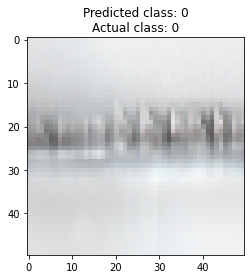

<Figure size 360x360 with 0 Axes>

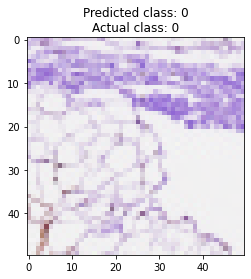

<Figure size 360x360 with 0 Axes>

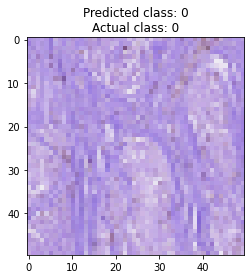

<Figure size 360x360 with 0 Axes>

In [ ]:
# Plot graph to show correctly predicted normal images
plotgraph (correctly_predicted_normal_df)

###### **Image Prediction - correctly predicted images for IDC presence**

The 3 patches below shows correctly predicted images for IDC presence. 

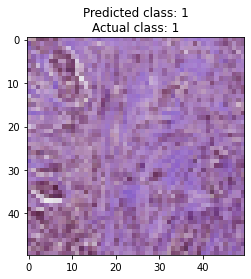

<Figure size 360x360 with 0 Axes>

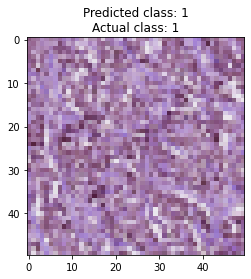

<Figure size 360x360 with 0 Axes>

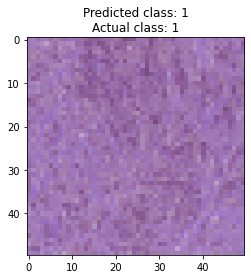

<Figure size 360x360 with 0 Axes>

In [ ]:
# Plot graph to show correctly predicted IDC images
plotgraph (correctly_predicted_idc_df)

### **Misclassification Analysis**

##### **Image Prediction - incorrectly predicted normal images**

The 3 patches shows IDC-present images that were incorrectly predicted to be normal. 

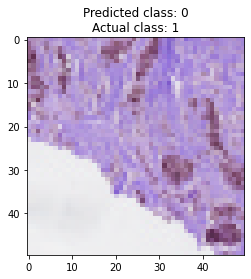

<Figure size 360x360 with 0 Axes>

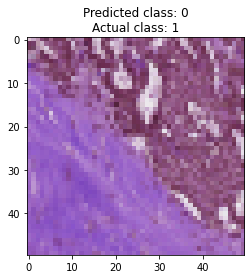

<Figure size 360x360 with 0 Axes>

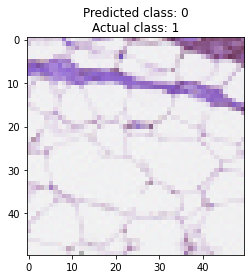

<Figure size 360x360 with 0 Axes>

In [ ]:
# Plot graph to show incorrectly predicted normal images
plotgraph (incorrectly_predicted_normal_df)

##### **Image Prediction - incorrectly predicted images with IDC presence**

The 3 patches shows normal images that were incorrectly predicted to have IDC presence. 

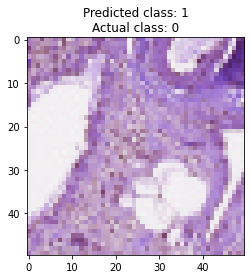

<Figure size 360x360 with 0 Axes>

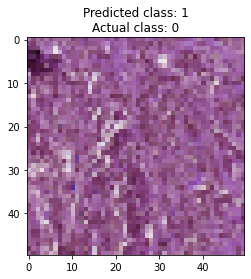

<Figure size 360x360 with 0 Axes>

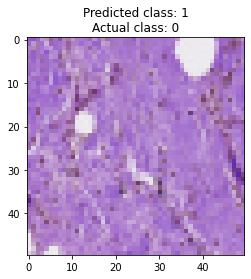

<Figure size 360x360 with 0 Axes>

In [ ]:
# Plot graph to show incorrectly predicted idc images
plotgraph (incorrectly_predicted_idc_df)

# **Conclusion**

The model is effective in meeting the objective of the firm in predicting the presence/absence of IDC with a 81.5% balanced accuracy score and a 76.0% recall score.

**Potentially save resources (time)**

It takes approximately 10 - 20 minutes for a pathologist to look through a histopathological image under a microscope.  It took the model less than 1 minute to predict for the presence or absence of IDC for more than 39,000 image patches. Assuming each patient has 1,000 image patches, the model is able to predict the presence of IDC for approximately 39 people.  Coupled with their expertise, pathologist could use this deep learning method to better predict images in a shorter time frame. 

**Less complex models had better predictive ability**

Less complex models (fewer convulational layers) appear to provide better predictive ability.


## **Limitation**

**Dataset limitations**

**Fragmented image patches**

The dataset comprises of extracted (50 by 50 pixels) images of whole slide images.  The machine, hence, is trained on the features found on indivdual image patches, rather than from the entire slide.  It could potentially miss out on learning about features as a whole and features that are connected between image patches that are cut off when the dataset is broken. 


## **Next Step**

**Trained on individuals with no cancer**

One of the issues is that the dataset contains data from cancer patients only. Hence, the machine is trained on both the "normal" and "IDC-positive" image patches from cancer patients. It would be beneficial if it were also trained on individuals who did not have breast cancer.    

**Other methodologies**

Recently, there have been more research done in the field of medical imagery diagnosis using deep learning techniques. Other possible methodologies that can be explored include ensemble neural network models. Ensemble learning combines the predictions from multiple neural network models to reduce the variance of predictions and reduce generalization error. [[Source]](https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/).  Additionally, image segmentation can be explored as a classification/prediction tool. Image segmentation aims to obtain region of interest. The parts into which the image is divided are based on the image properties (similarity, discontinuity etc). It aims to segment an image into different areas for better analysis. [[Source]](https://www.analyticsvidhya.com/blog/2021/09/image-segmentation-algorithms-with-implementation-in-python/)

**Whole Slide Imagery**

Explore utilising the whole slide imagery as opposed to relevant fragments

**Aggressiveness Rating**

Explore automatically assigning aggressivness rating based on the extent of IDC-presence in whole slide imagery. 



# **Appendix**

## **Visual display of models**

### **Baseline model** 

In [183]:
baseline_v3 = load_model('/content/gdrive/My Drive/baseline_v3.h5')

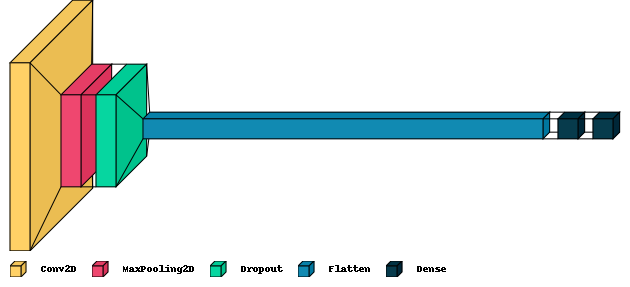

In [184]:
model_dis = baseline_v3

visualkeras.layered_view(model_dis).show() # display using your system viewer
visualkeras.layered_view(model_dis, to_file='output.png') # write to disk
visualkeras.layered_view(model_dis, to_file='output.png').show() # write and show

visualkeras.layered_view(model_dis, spacing=15, legend=True)

In [185]:
baseline_v3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        1568      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 16928)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2166912   
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                      

### **VGG16 model** 

In [ ]:
vgg_model_v1 = load_model('/content/gdrive/My Drive/vgg_model_v1.h5')

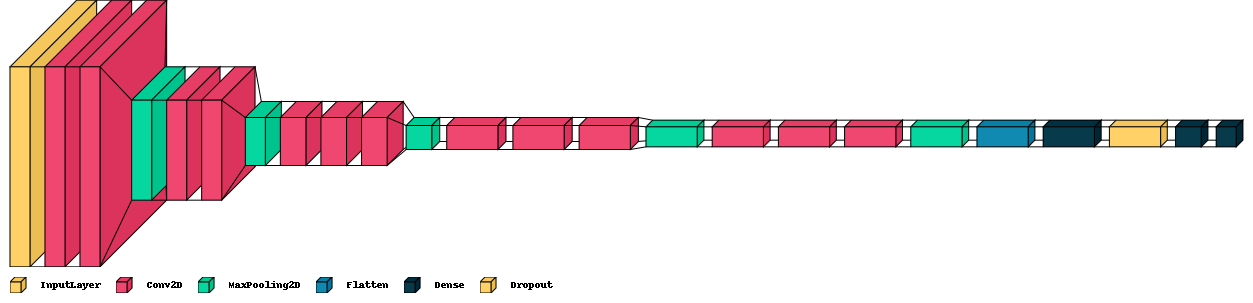

In [ ]:
model_dis = vgg_model_v1

visualkeras.layered_view(model_dis).show() # display using your system viewer
visualkeras.layered_view(model_dis, to_file='output.png') # write to disk
visualkeras.layered_view(model_dis, to_file='output.png').show() # write and show

visualkeras.layered_view(model_dis, spacing=15, legend=True)

In [ ]:
vgg_model_v1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### **Resnet50 model** 


In [ ]:
resnet50_dis = load_model('/content/gdrive/My Drive/breastcancer/resnet50_model_v2_strat.h5')

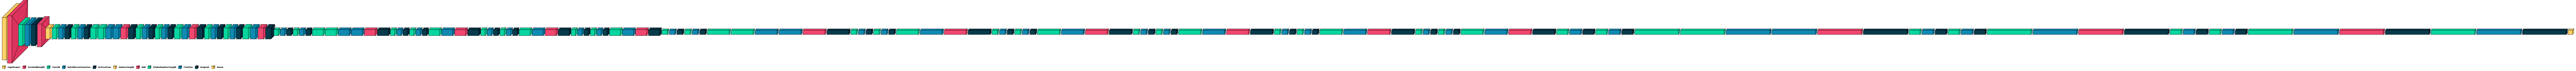

In [ ]:
model_dis = resnet50_dis

visualkeras.layered_view(model_dis).show() # display using your system viewer
visualkeras.layered_view(model_dis, to_file='output.png') # write to disk
visualkeras.layered_view(model_dis, to_file='output.png').show() # write and show

visualkeras.layered_view(model_dis,legend=True)

In [ ]:
resnet50_dis.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                            